In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 40.9MB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
print(tf.__version__)

2.1.0


In [4]:
# Load
mnist_dataset = tf.keras.datasets.mnist.load_data()
# Unpack
(x_train, y_train), (x_test, y_test) = mnist_dataset

# Train dataset shapes
print('Train X shape ', x_train.shape)
print('Train Y shape ', y_train.shape)

# Test dataset shapes
print('Test X shape ', x_test.shape)
print('Test Y shape ', y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train X shape  (60000, 28, 28)
Train Y shape  (60000,)
Test X shape  (10000, 28, 28)
Test Y shape  (10000,)


In [0]:
def print_statistic(dataset, name):
  """
  Print basic statistics about on dataset
  Including
    - number of unique values
    - min and max values
    - standard deviation (std)
    - mean
  :param dataset: data set
  :return: void
  """
  value_count = len(np.unique(dataset))
  min_value = np.min(dataset)
  max_value = np.max(dataset)
  std = np.std(dataset)
  mean = np.mean(dataset)

  print("{} unique values:".format(name), value_count,
        "\nmin value:", min_value,
        "\nmax value:", max_value,
        "\nstd:", std,
        "\nmean:", mean)

In [6]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]
print("train examples", m_train,
      "\ntest examples", m_test)

print_statistic(x_train, "pixel")

print_statistic(y_train, "label")

train examples 60000 
test examples 10000
pixel unique values: 256 
min value: 0 
max value: 255 
std: 78.56748998339798 
mean: 33.318421449829934
label unique values: 10 
min value: 0 
max value: 9 
std: 2.889246360020012 
mean: 4.4539333333333335


In [0]:
def dataset_distributions(training_set, test_set):
  """
  Get distributions of the training and test set
  :param training_set: training set
  :param test_set: test set
  :return: distributions in percentage in a dataframe
  """
  training_set_df = pd.DataFrame({'label': training_set})
  test_set_df = pd.DataFrame({'label': test_set})
  
  m_train = training_set.shape[0]
  m_test = test_set.shape[0]

  train_distribution = training_set_df.groupby(["label"], as_index=False)["label"].size() * 100 / m_train
  test_distribution = test_set_df.groupby(["label"], as_index=False)["label"].size()* 100 / m_test

  train_test_distributions = pd.DataFrame({'train': train_distribution, 'test': test_distribution})
  return train_test_distributions


In [0]:
def print_dataset_distributions(dataset_distributions):
  """
  Print an histogram from dataset distributions
  :param dataset_distributions: dataframe with distributions
  :return: void
  """
  # x locations
  labels = dataset_distributions.index
  # width of the bars
  width = 0.35

  fig, ax = plt.subplots(figsize = (14,10))
  ax.bar(labels - width / 2, dataset_distributions['train'], width, label='train')
  ax.bar(labels + width / 2, dataset_distributions['test'], width, label='test')

  ax.set_ylabel('%')
  ax.set_xlabel('Label')
  ax.set_xticks(labels)
  ax.set_xticklabels(labels)
  ax.legend(loc='lower right')
  ax.set_title('Distribution of labels across training and test set')

  plt.savefig('label-distributions.png')

           train   test
label                  
0       9.871667   9.80
1      11.236667  11.35
2       9.930000  10.32
3      10.218333  10.10
4       9.736667   9.82
5       9.035000   8.92
6       9.863333   9.58
7      10.441667  10.28
8       9.751667   9.74
9       9.915000  10.09


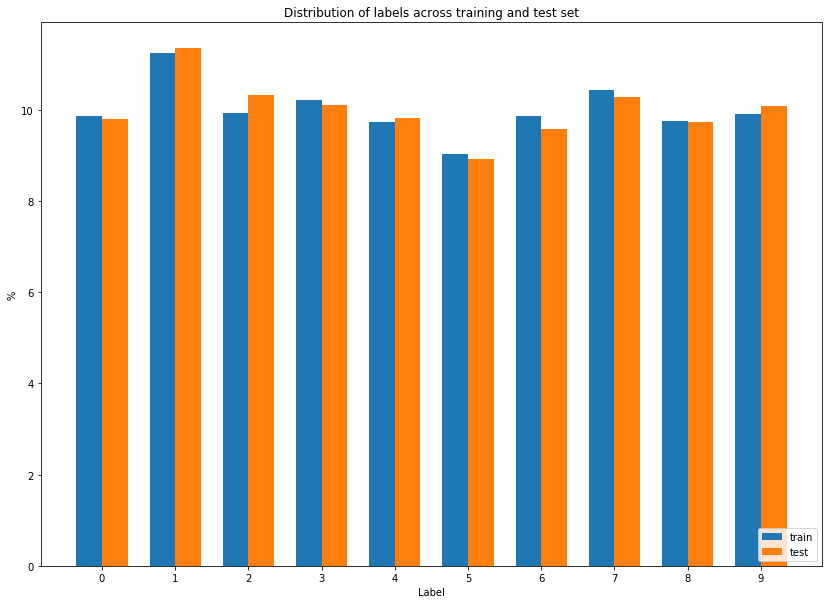

In [9]:
traintest = dataset_distributions(y_train, y_test)
print(traintest)

print_dataset_distributions(traintest)


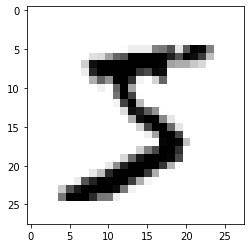

In [10]:
def show_image(dataset, image_index):
  """
  Print an image
  :param dataset: (Tensor) dataset
  :param image_index: (integer)
  :return: void
  """
  height = dataset.shape[1]
  width = dataset.shape[2]

  image = dataset[image_index]
  image = image.reshape(height, width)
  plt.imshow(image, cmap=plt.get_cmap('gray_r'))

  plt.show()

show_image(x_train, 0)

In [0]:
def prepare_mnist_dataset(mnist_dataset):
  """
  Get the data form MNIST dataset
  http://yann.lecun.com/exdb/mnist/
  :param mnist_dataset: MNIST dataset
  :return: tuple containing (x_train, y_train), (x_test, y_test)
  """
  (x_train, y_train), (x_test, y_test) = mnist_dataset
  # Reduce the samples from integers
  x_train, x_test = x_train / np.float32(255), x_test / np.float32(255)
  y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
  # Get the number of training and test samples
  m_train = x_train.shape[0]
  m_test = x_test.shape[0]
  # Get image dimensions
  height = x_test.shape[1]
  width = x_test.shape[2]
  # Reshape adding one dimension for the channel
  x_train = x_train.reshape(m_train, height, width, 1)
  x_test = x_test.reshape(m_test, height, width, 1)
  return (x_train, y_train), (x_test, y_test)

In [0]:
def batch_dataset(dataset, take_count, batch_count, shuffle_count=None):
  """
  Shuffle and batch the data
  :param dataset: the dataset
  :param take_count: how many samples are kept
  :param batch_count: Batch count
  :param shuffle_count: Shuffle count
  :return: dataset batched
  """
  # For perfect shuffling, a buffer size greater 
  # than or equal to the full size of the dataset is required.
  if shuffle_count is None:
    shuffle_count = take_count
  
  batched_dataset = dataset.take(take_count).shuffle(shuffle_count, seed=42).batch(batch_count)
  return batched_dataset

In [0]:
class SimpleConvModel(Model):
  """
  Custom convolutional model
  """
  def __init__(self, image_height, image_width, channel_count):
    """
    Constructor
    :param self: self
    :param image_height: height of image in pixel
    :param image_width: width of image in pixel
    :channel_count: channel count, for example color image has 3 channels, grayscale image has only one channel
    :return: void
    """
    super(SimpleConvModel, self).__init__()

    # Define sequential layers
    self.convolution = Conv2D(32, (3,3), input_shape=(image_height, image_width, channel_count), activation="relu")
    self.max_pooling = MaxPooling2D(2, 2)
    self.flatten = Flatten()
    self.dense = Dense(128, activation="relu")
    self.softmax = Dense(10, activation="softmax")

    # Keep convolutional layer output
    self.convolutional_output = tf.constant(0)
    # Keep max pooling layer output
    self.max_pooling_output = tf.constant(0)
    # Input signature for tf.saved_model.save()
    self.input_signature = tf.TensorSpec(shape=[None, image_height, image_width, channel_count], dtype=tf.float32, name='prev_img')

  def call(self, inputs):
    """
    Forward propagation
    :param self: self
    :param inputs: tensor of dimension [batch_size, image_height, image_width, channel_count]
    :return: predictions
    """
    self.convolutional_output = self.convolution(inputs)
    self.max_pooling_output = self.max_pooling(self.convolutional_output)
    x = self.flatten(self.max_pooling_output)
    x = self.dense(x)
    return self.softmax(x)


In [0]:
optimizer_function = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
def compute_accuracy(labels, logits):
  """
  Compute accuracy
  :param labels: true label
  :param logits: predicted label
  :return: accuracy of type float
  """
  predictions = tf.math.argmax(logits, axis=1)
  return tf.math.reduce_mean(tf.cast(tf.math.equal(predictions, labels), tf.float32))

In [0]:
def compute_loss(labels, logits):
  """
  Compute loss
  :param labels: true label
  :param logits: predicted label
  :return: loss
  """
  return loss_function(labels, logits)

In [17]:
# Create a model instance
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

model = SimpleConvModel(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
model.build(input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, 1))
model.summary()

Model: "simple_conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  692352    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Prepare data
(x_train, y_train), (x_test, y_test) = prepare_mnist_dataset(mnist_dataset)

# Train
# Get a `TensorSliceDataset` object from `ndarray`s
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset_batch = batch_dataset(train_dataset,
                        take_count = 60000,
                        batch_count = 100)

# Test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset_batch = test_dataset.batch(100)

In [0]:
def save(model, path):
  """
  export saved model
  :param model: model to save
  :param path: file path
  :return: void
  """
  signature_dict = {'model': tf.function(model, input_signature = [model.input_signature])}
  tf.saved_model.save(model, path, signature_dict)

In [20]:
EPOCHS = 10

train_losses = []
train_accurarcies = []

test_losses = []
test_accurarcies = []

epoch_stop = 0

for epoch in range(EPOCHS):
  train_loss_aggregate = tf.keras.metrics.Mean(name="train_loss")
  test_loss_aggregate = tf.keras.metrics.Mean(name="test_loss")
  train_accuracy_aggregate = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
  test_accuracy_aggregate = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

  for train_images, train_labels in train_dataset_batch:
    with tf.GradientTape() as tape:
      # forward propagation
      predictions = model(train_images)
      # calculate loss
      loss = compute_loss(train_labels, predictions)
      
    # calculate gradients from model definition and loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # update model from gradients
    optimizer_function.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss_aggregate(loss)
    train_accuracy_aggregate(train_labels, predictions)

  for test_images, test_labels in test_dataset_batch:
    predictions = model(test_images)

    loss = compute_loss(test_labels, predictions)

    test_loss_aggregate(loss)
    test_accuracy_aggregate(test_labels, predictions)

  train_losses.append(train_loss_aggregate.result().numpy())
  train_accurarcies.append(train_accuracy_aggregate.result().numpy()*100)

  test_losses.append(test_loss_aggregate.result().numpy())
  test_accurarcies.append(test_accuracy_aggregate.result().numpy()*100)

  print('epoch', epoch,
        'train loss', train_losses[-1],
        'train accuracy', train_accurarcies[-1],
        'test loss', test_losses[-1],
        'test accuracy', test_accurarcies[-1])

  save(model, 'mnist/epoch/{0}'.format(epoch))
  
  epoch_stop = epoch
  
  if epoch > 1:
    if test_accurarcies[-2] >= test_accurarcies[-1] and test_accurarcies[-3] >= test_accurarcies[-2]:
      break
  

epoch 0 train loss 0.2019603 train accuracy 94.14166808128357 test loss 0.07888014 test accuracy 97.54999876022339
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mnist/epoch/0/assets
epoch 1 train loss 0.064292975 train accuracy 98.07999730110168 test loss 0.057503365 test accuracy 98.089998960495
INFO:tensorflow:Assets written to: mnist/epoch/1/assets
epoch 2 train loss 0.043002833 train accuracy 98.71166944503784 test loss 0.05409672 test accuracy 98.089998960495
INFO:tensorflow:Assets written to: mnist/epoch/2/assets
epoch 3 train loss 0.031002931 train accuracy 99.05166625976562 test loss 0.046595603 test accuracy 98.43999743461609
INFO:tensorflow:Assets written to: mnist/epoch/3/assets
epoch 4 train loss 0.022615613 train accuracy 99.31166768074036 test loss 0.04606781 test accuracy 98.43000173568726
INFO:tensorflow:Assets written to: mnist/epoch/4/assets
epoch 5 train loss 0.016122704 train accuracy 99.505001306

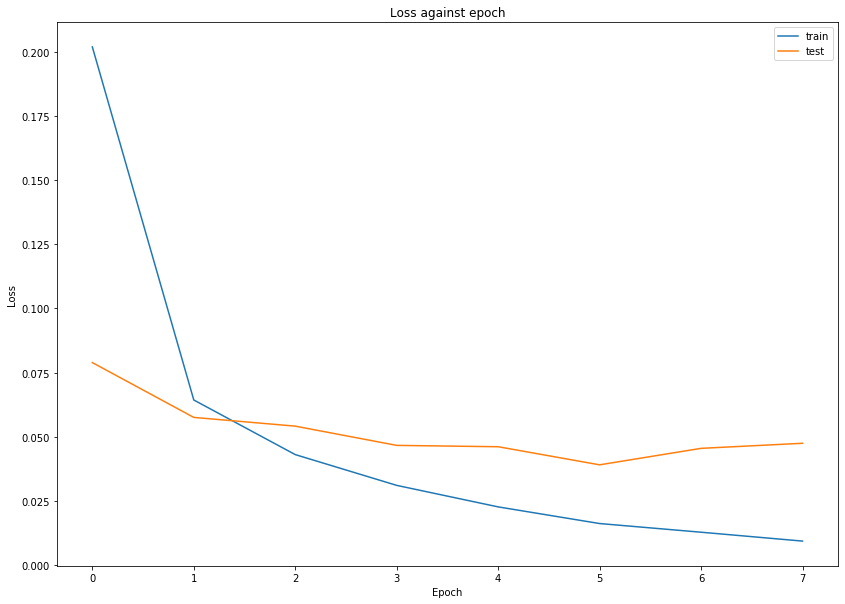

In [21]:
# Train/Test losses
fig, ax = plt.subplots(figsize = (14,10))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss against epoch')
ax.legend(loc='upper right')

plt.savefig('losses.png')

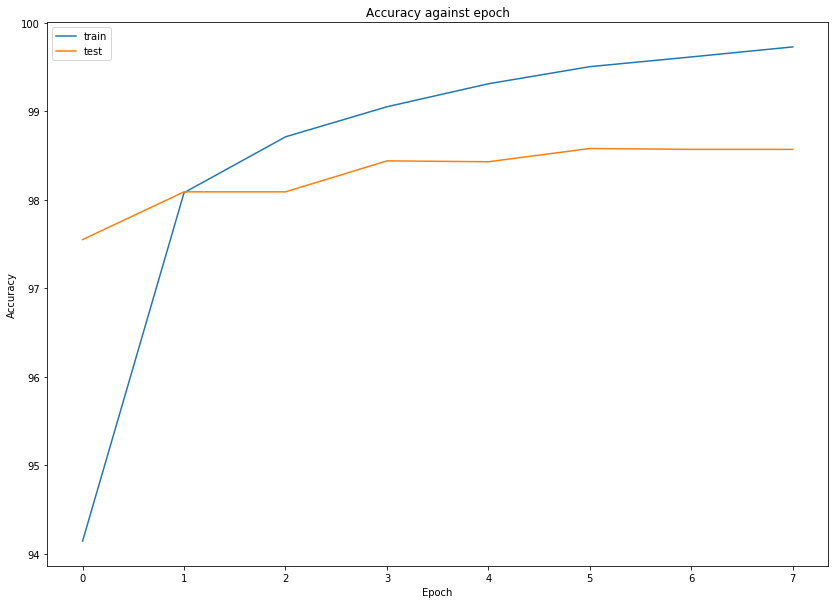

In [22]:
# Train/Test accuracies
fig, ax = plt.subplots(figsize = (14,10))
plt.plot(train_accurarcies, label='train')
plt.plot(test_accurarcies, label='test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy against epoch')
ax.legend(loc='upper left')

plt.savefig('accuracies.png')

In [0]:
def custom_confusion_matrix(model, images, labels):
  """
  Get a custom confusion matrix containing:
    - true positives on diagonal
    - recalls on the last column
    - precisions on the last row
  :param model:
  :param images:
  :param labels:
  :return:
  """
  m = images.shape[0]
  height = images.shape[1]
  width = images.shape[2]

  # calculate prediction
  test_predictions = model(images.reshape(m, height, width, 1))
  confusion = confusion_matrix(labels, np.argmax(test_predictions,axis=1))
  confusion = confusion.astype('float64')

  recalls = np.round(np.diagonal(confusion) * 100 / np.sum(confusion, axis=1), 2)
  precisions = np.round(np.diagonal(confusion) * 100 / np.sum(confusion, axis=0), 2)

  accuracy = np.round(compute_accuracy(labels, test_predictions).numpy() * 100, 2)
  precisions = np.append(precisions, accuracy)
  
  confusion = np.column_stack((confusion, recalls))
  confusion = np.vstack((confusion, precisions))

  return confusion

def print_confusion(confusion, value_max, epoch):
  """
  Print confusion matrix
  :param confusion: confusion matrix
  :param value_max: maximum value for heatmap
  :return: void
  """
  fig = plt.figure(figsize = (14,10))
  heatmap = sns.heatmap(confusion, annot=True, cbar=False, fmt='g', vmin=0, vmax=value_max)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  plt.savefig('confusion-epoch-{}.png'.format(epoch))

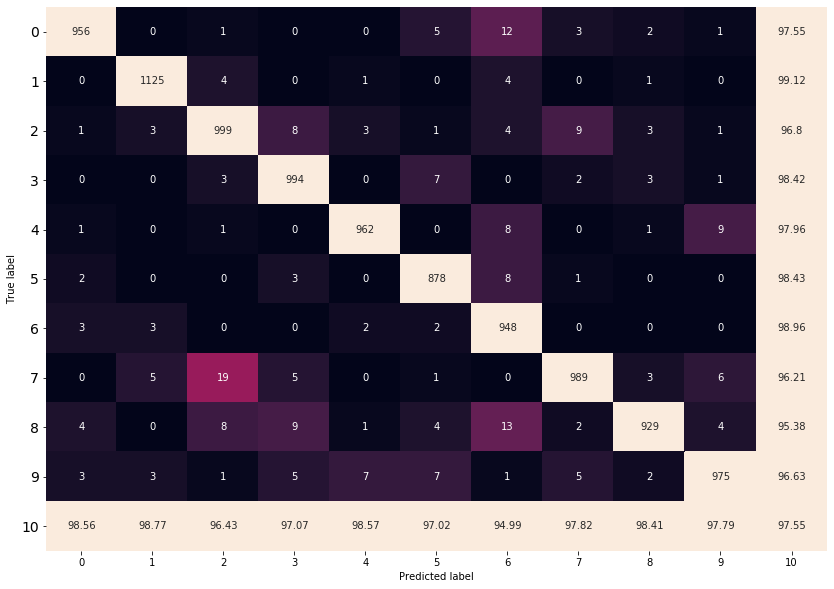

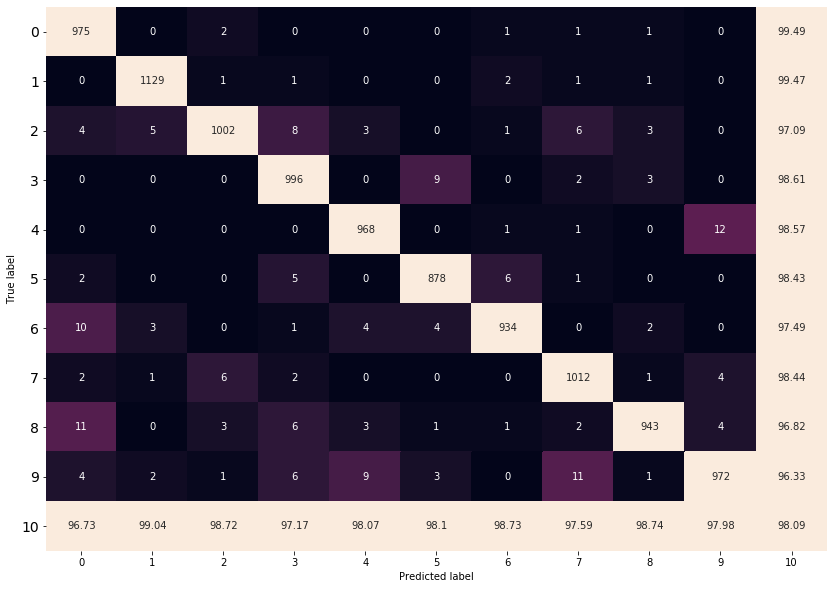

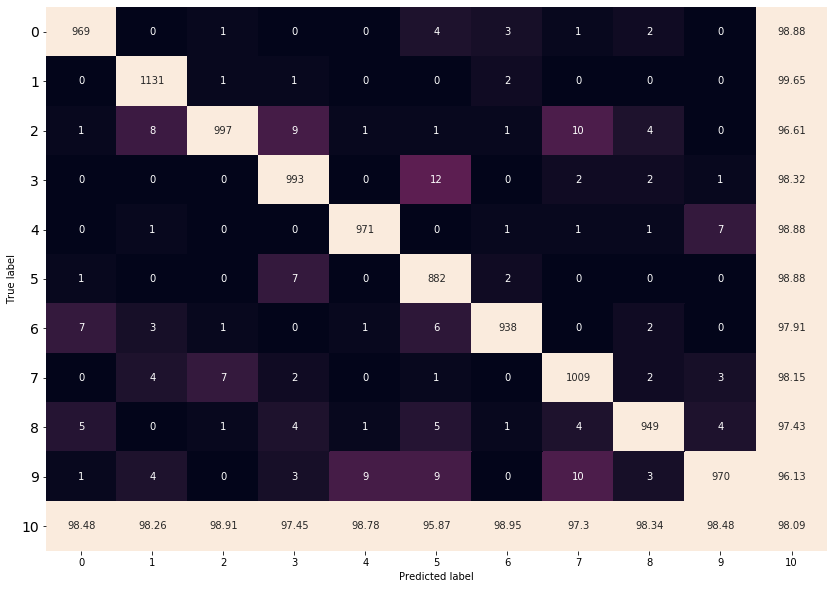

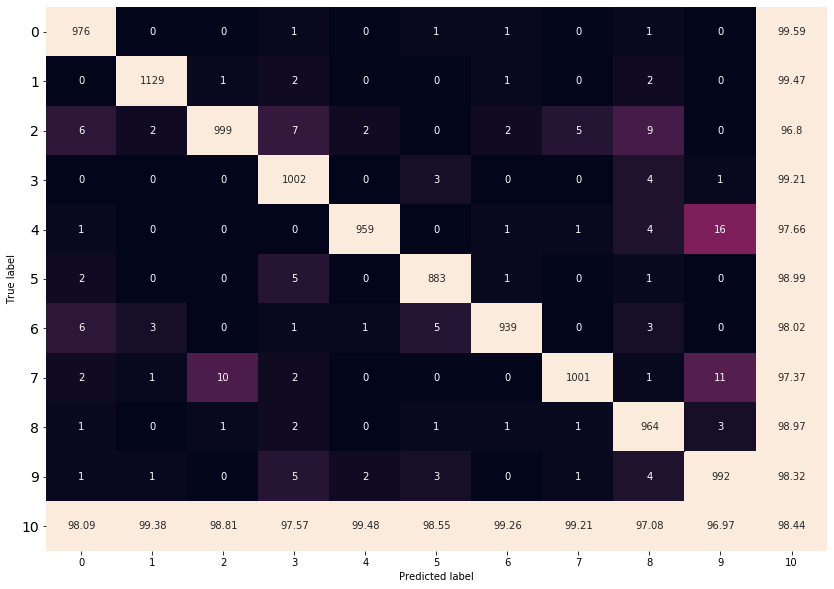

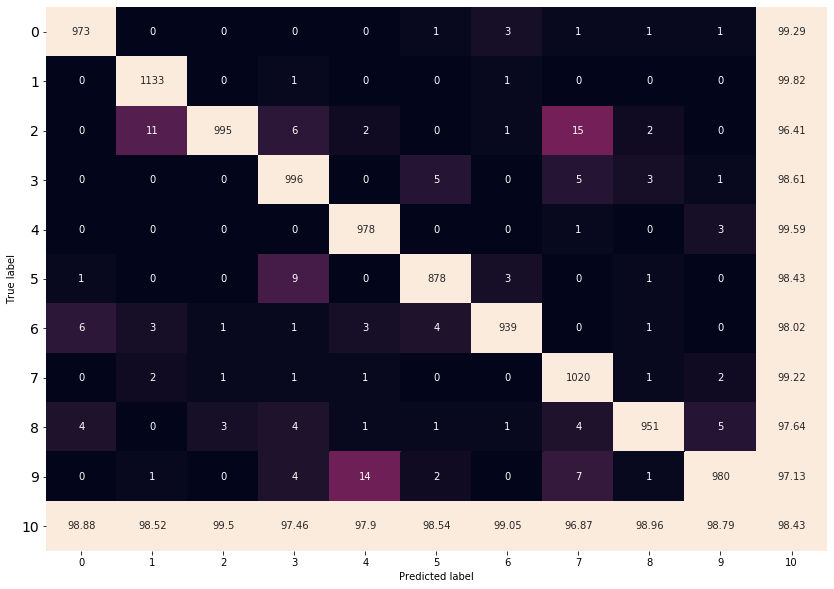

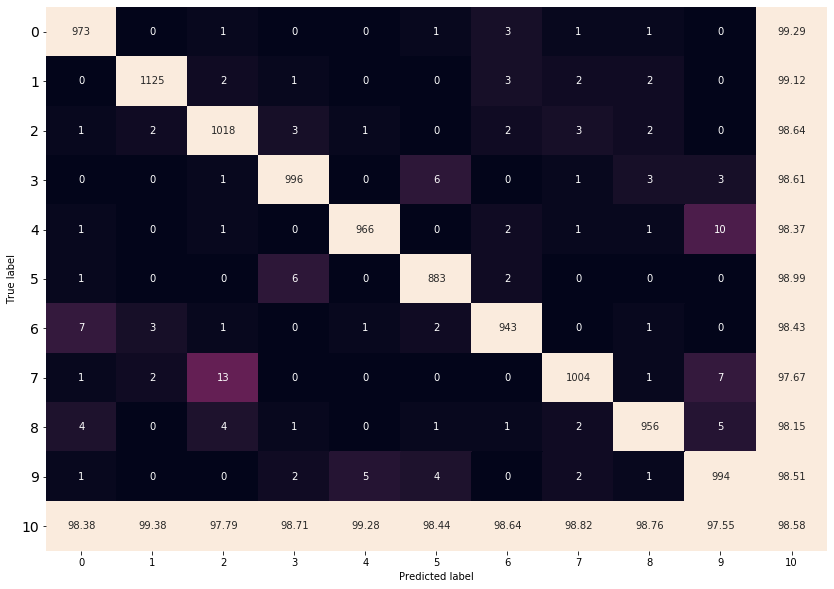

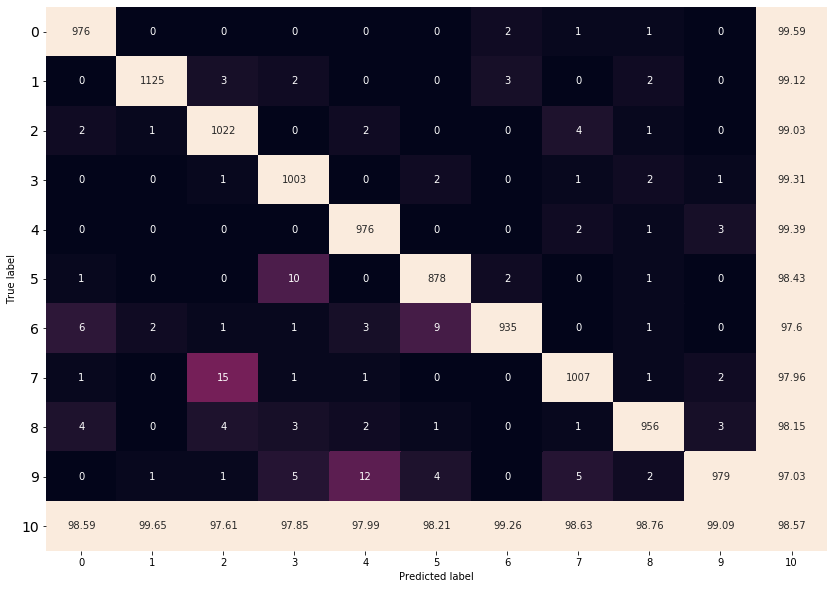

In [24]:
value_max = 50
for epoch in range(epoch_stop + 1):
  loaded_model = tf.saved_model.load("mnist/epoch/{0}".format(epoch))
  confusion = custom_confusion_matrix(loaded_model, x_test, y_test)
  if value_max == 0:
    value_max = np.max(confusion)
  
  print_confusion(confusion, value_max, epoch)
  

In [0]:
def print_convolutions(model):
  """
  Print convolution outputs
  :param model: model
  :return: void
  """
  print("convolution shape:", model.convolutional_output.shape)
  
  count = model.convolutional_output.shape[-1]

  # print all convolution outputs
  for index in range(0, count):
    convolution = model.convolutional_output[0, :, :, index]
    
    plt.title("Convolution n°{}".format(index + 1))
    plt.imshow(convolution, cmap=plt.get_cmap('gray_r'))
    plt.show()

def print_max_poolings(model):
  """
  Print max pooling outputs
  :param model: model
  :return: void
  """
  print("max pooling shape:", model.max_pooling_output.shape)

  count = model.max_pooling_output.shape[-1]

  # print all max pooling outputs
  for index in range(0, count):
    max_pooling = model.max_pooling_output[0, :, :, index]
    
    plt.title("Max pooling n°{}".format(index + 1))
    plt.imshow(max_pooling, cmap=plt.get_cmap('gray_r'))
    plt.show()


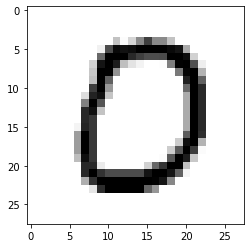

label 0
prediction [0]
convolution shape: (1, 26, 26, 32)


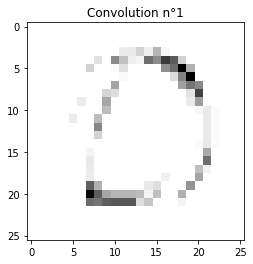

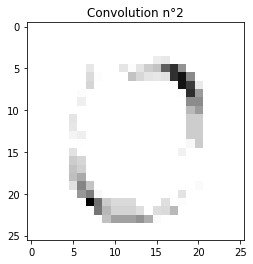

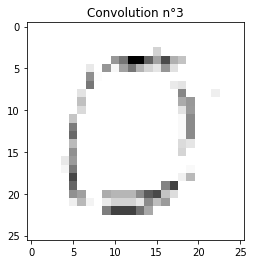

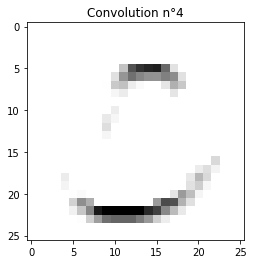

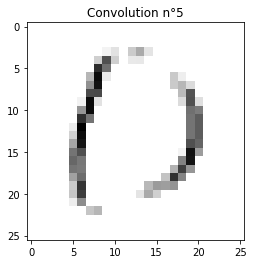

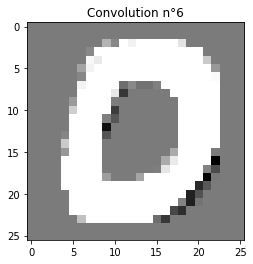

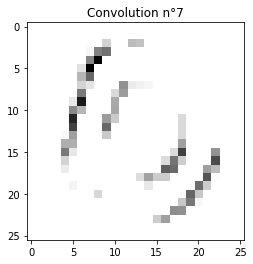

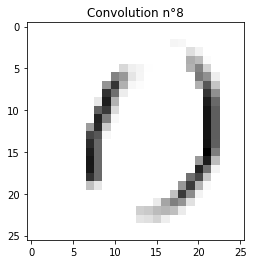

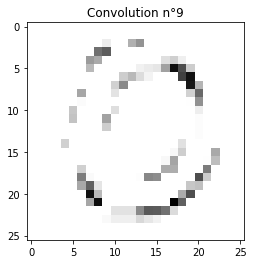

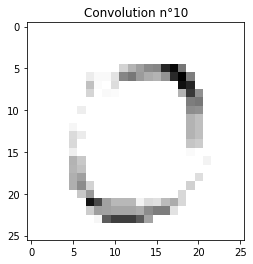

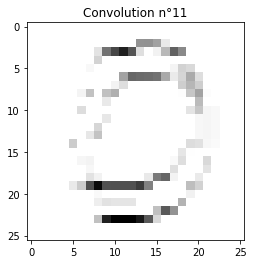

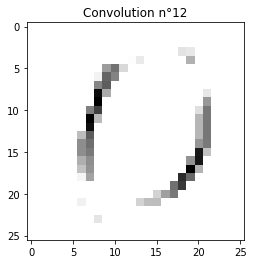

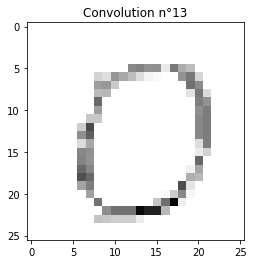

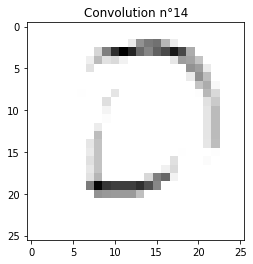

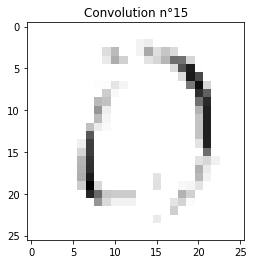

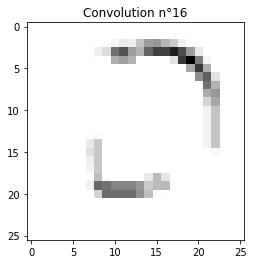

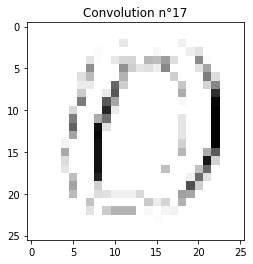

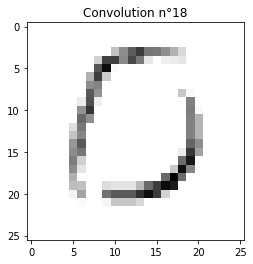

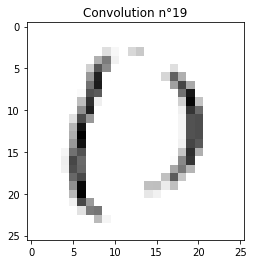

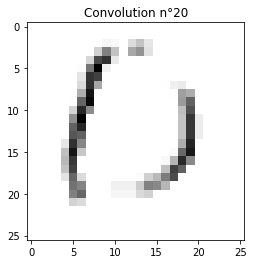

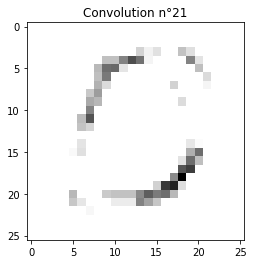

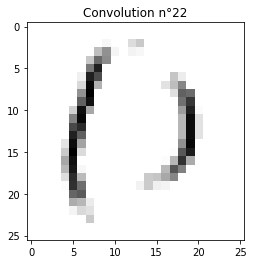

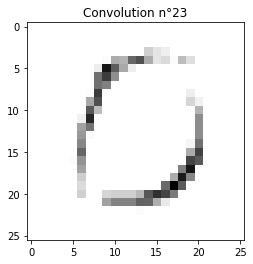

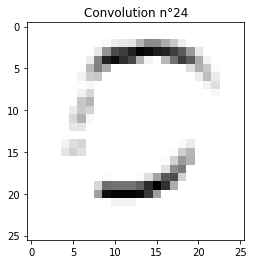

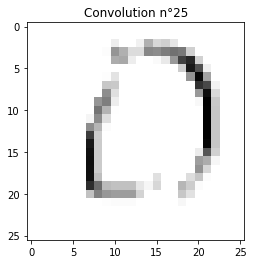

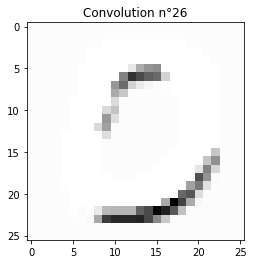

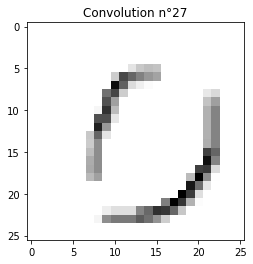

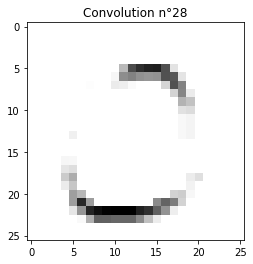

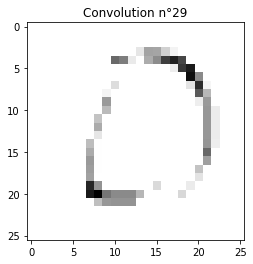

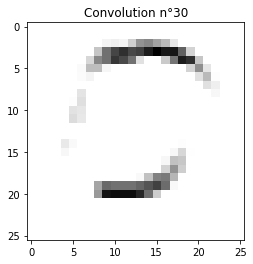

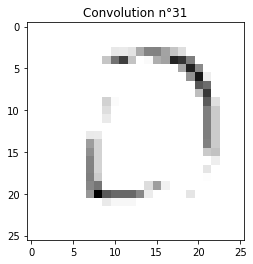

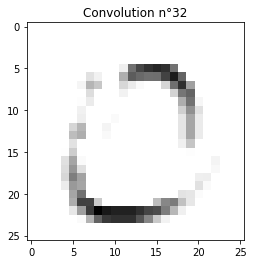

max pooling shape: (1, 13, 13, 32)


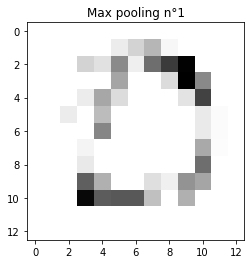

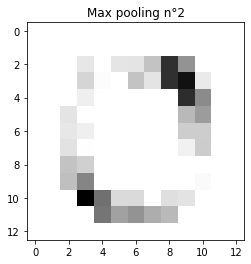

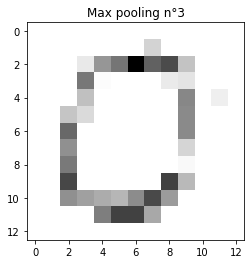

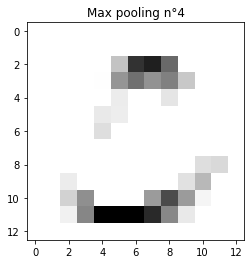

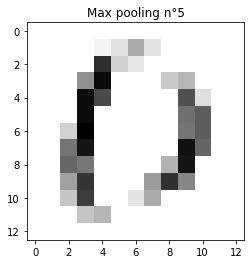

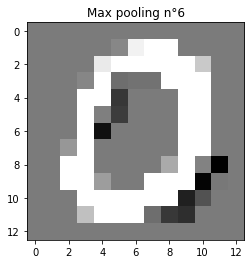

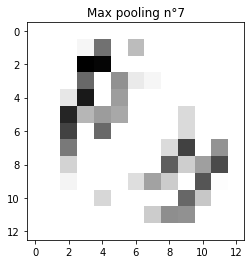

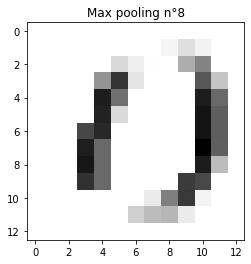

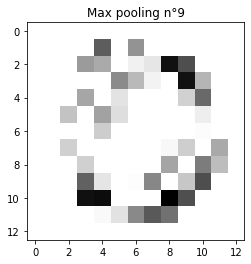

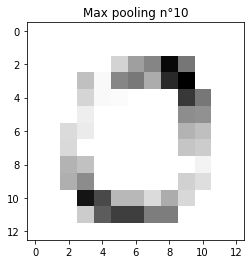

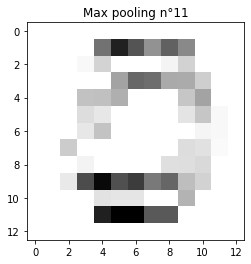

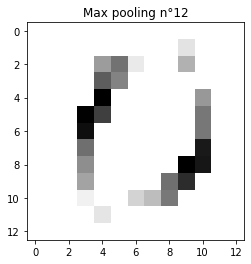

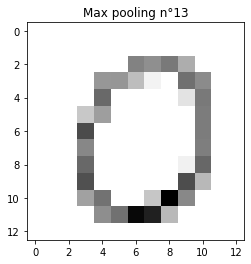

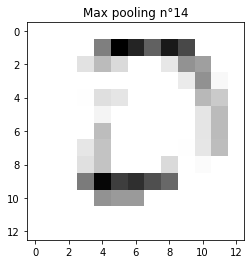

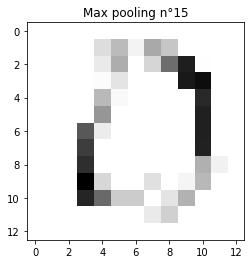

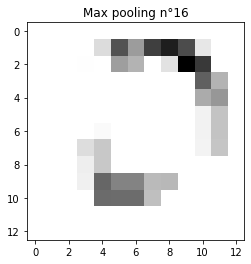

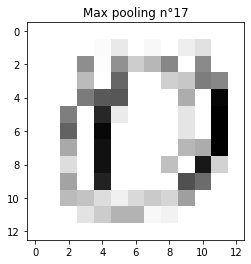

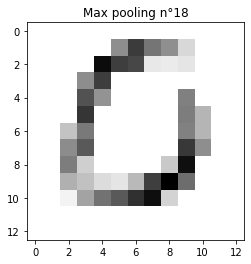

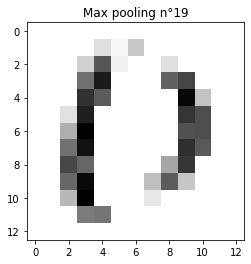

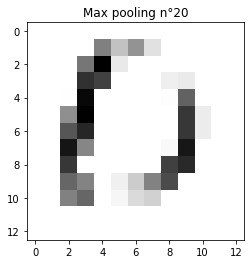

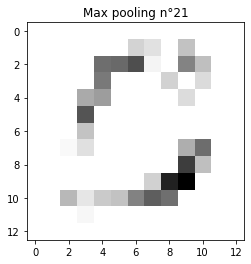

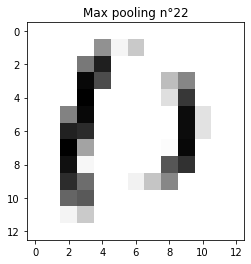

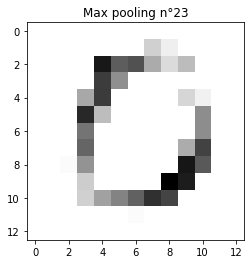

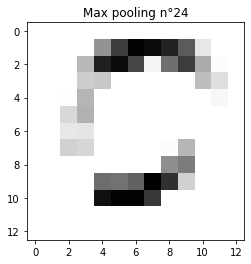

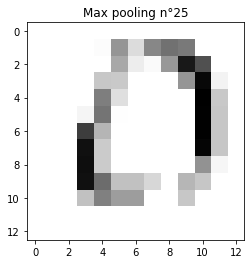

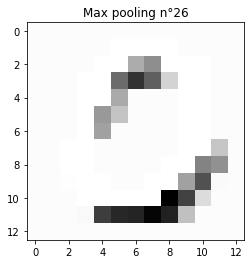

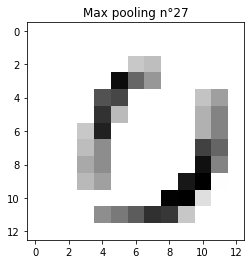

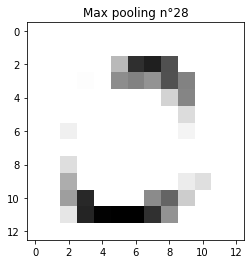

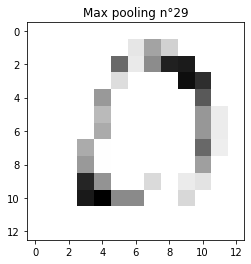

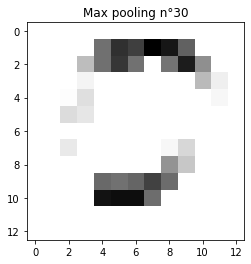

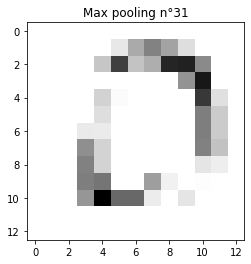

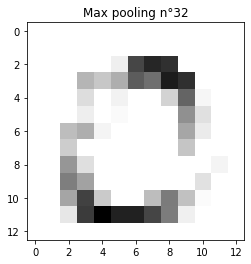

In [26]:
sample_index = 10
show_image(x_test, sample_index)

prediction = model(x_test[sample_index].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 1))

print("label", y_test[sample_index])
print("prediction", tf.math.argmax(prediction, axis=1).numpy())

print_convolutions(model)
print_max_poolings(model)

In [27]:
# Error analysis
epoch = 5
savedModel = tf.saved_model.load("mnist/epoch/{0}".format(epoch))

m = x_test.shape[0]

# calculate prediction
test_predictions = model(x_test.reshape(m, IMAGE_HEIGHT, IMAGE_WIDTH, 1))
error_indices = y_test != np.argmax(test_predictions, axis=1)

error_images = x_test[error_indices]
error_labels = y_test[error_indices]
error_predictions = test_predictions[error_indices]

errors = pd.DataFrame({'label': error_labels, 'prediction': np.argmax(error_predictions, axis=1)})
print(errors)

     label  prediction
0        3           5
1        4           0
2        2           7
3        5           3
4        6           0
..     ...         ...
138      4           9
139      2           7
140      3           9
141      3           2
142      5           6

[143 rows x 2 columns]


index 0
true label 3
prediction 5
top k [5 8 3] [0.868251   0.09973314 0.03146871]


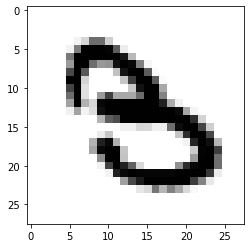

index 1
true label 4
prediction 0
top k [0 4 2] [0.78798175 0.2111437  0.00070876]


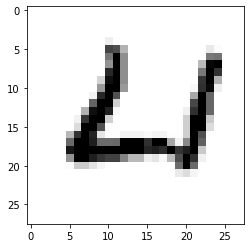

index 2
true label 2
prediction 7
top k [7 2 8] [0.984574   0.01402558 0.0010422 ]


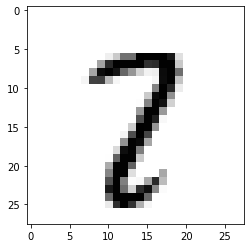

index 3
true label 5
prediction 3
top k [3 5 4] [0.88965327 0.11025357 0.00004264]


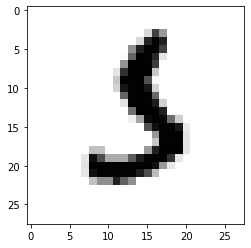

index 4
true label 6
prediction 0
top k [0 6 5] [0.56225854 0.43686298 0.0007547 ]


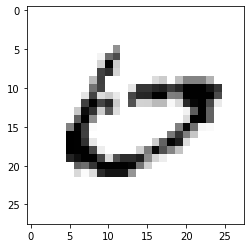

index 5
true label 3
prediction 5
top k [5 3 8] [0.6260293  0.37396646 0.00000429]


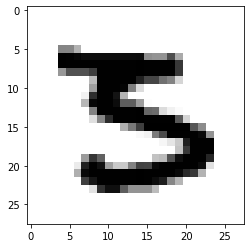

index 6
true label 2
prediction 8
top k [8 2 9] [0.91156584 0.0883924  0.00003812]


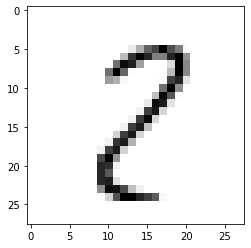

index 7
true label 2
prediction 1
top k [1 7 2] [0.9413052  0.03226917 0.02430581]


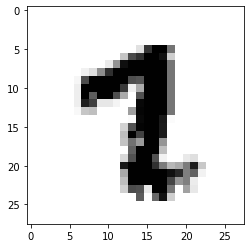

index 8
true label 0
prediction 6
top k [6 5 0] [0.8669311  0.07159954 0.06063024]


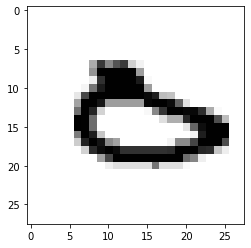

index 9
true label 9
prediction 7
top k [7 9 3] [0.897537   0.10231091 0.00005762]


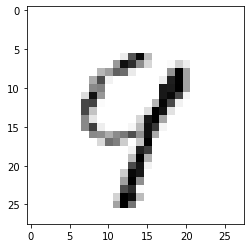

index 10
true label 3
prediction 5
top k [5 3 9] [0.96881133 0.03114203 0.00003849]


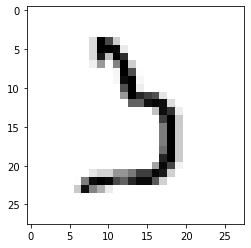

index 11
true label 3
prediction 5
top k [5 3 8] [0.7519887  0.24793416 0.00007598]


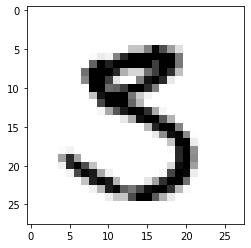

index 12
true label 8
prediction 9
top k [9 8 7] [0.9937251  0.00570977 0.00038976]


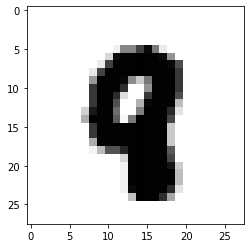

index 13
true label 1
prediction 2
top k [2 1 6] [0.85164547 0.09786887 0.03530718]


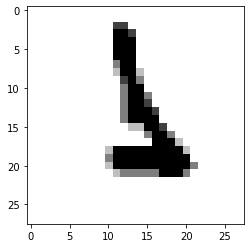

index 14
true label 6
prediction 5
top k [5 0 3] [0.99909115 0.00086976 0.0000134 ]


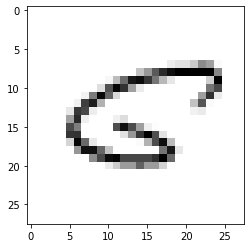

index 15
true label 7
prediction 2
top k [2 3 1] [0.6603156  0.23069839 0.06274029]


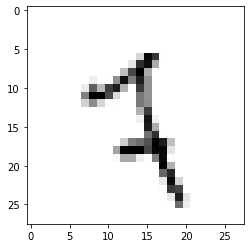

index 16
true label 4
prediction 6
top k [6 4 0] [0.99900836 0.00095223 0.00002302]


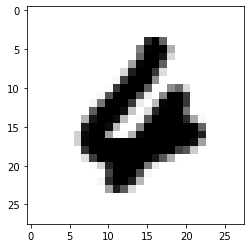

index 17
true label 4
prediction 7
top k [7 4 1] [0.9649213  0.03498059 0.00005673]


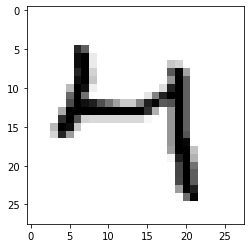

index 18
true label 7
prediction 2
top k [2 7 1] [0.69432753 0.30460703 0.00099562]


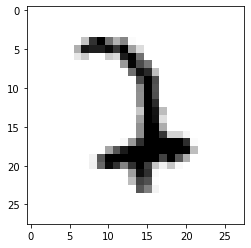

index 19
true label 9
prediction 0
top k [0 9 4] [0.37029114 0.27018484 0.19769177]


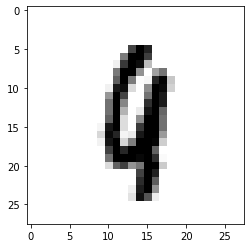

index 20
true label 4
prediction 9
top k [9 4 1] [0.986405   0.01336832 0.00012896]


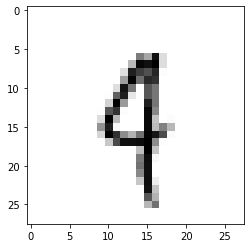

index 21
true label 9
prediction 5
top k [5 3 9] [0.9527038  0.02442923 0.0145794 ]


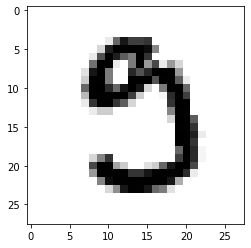

index 22
true label 7
prediction 1
top k [1 7 9] [0.7765867  0.22281623 0.00022545]


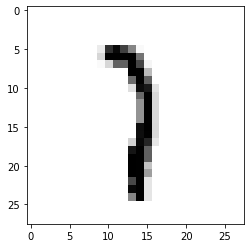

index 23
true label 8
prediction 0
top k [0 8 5] [0.98827785 0.01033858 0.00089311]


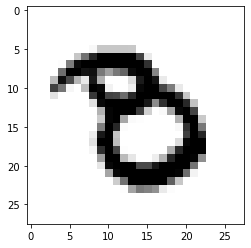

index 24
true label 5
prediction 6
top k [6 5 8] [0.6290262  0.37052462 0.00031015]


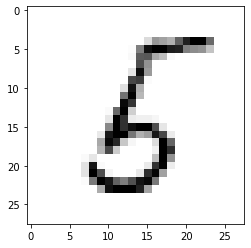

index 25
true label 5
prediction 3
top k [3 5 8] [0.74234223 0.25696495 0.00036716]


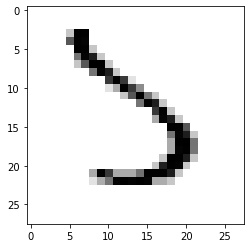

index 26
true label 2
prediction 7
top k [7 2 3] [0.8917417  0.10624416 0.00190112]


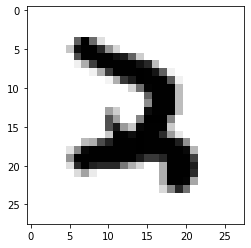

index 27
true label 8
prediction 7
top k [7 8 9] [0.9977882  0.00219234 0.00001849]


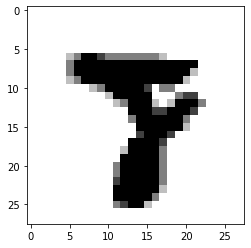

index 28
true label 4
prediction 6
top k [6 4 2] [0.98073936 0.01811963 0.00113465]


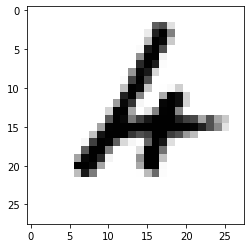

index 29
true label 0
prediction 6
top k [6 0 5] [0.99978286 0.00021709 0.00000013]


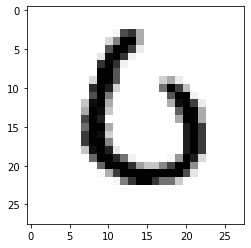

index 30
true label 5
prediction 6
top k [6 5 8] [0.6385692  0.36141628 0.00000642]


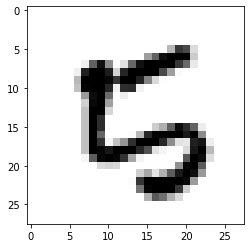

index 31
true label 2
prediction 0
top k [0 2 7] [0.6146111  0.38529405 0.00005563]


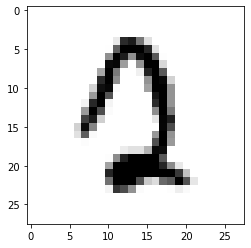

index 32
true label 3
prediction 7
top k [7 3 9] [0.54941916 0.39145762 0.05901041]


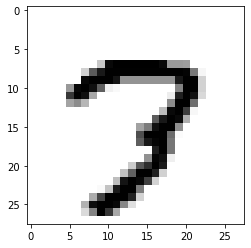

index 33
true label 8
prediction 6
top k [6 8 5] [0.9750308  0.02453388 0.00043371]


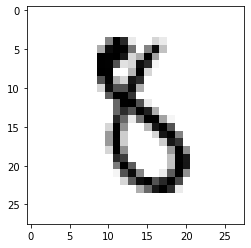

index 34
true label 9
prediction 3
top k [3 5 9] [0.49253216 0.33600542 0.14820412]


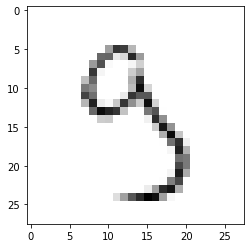

index 35
true label 8
prediction 0
top k [0 8 9] [0.8925744  0.10553211 0.00146169]


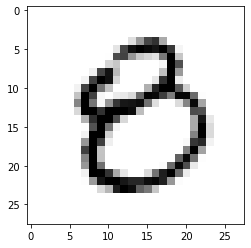

index 36
true label 7
prediction 2
top k [2 7 1] [0.6201446  0.37845862 0.00120652]


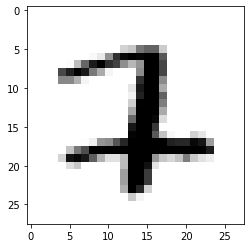

index 37
true label 2
prediction 7
top k [7 9 2] [0.9405391  0.03686701 0.01925783]


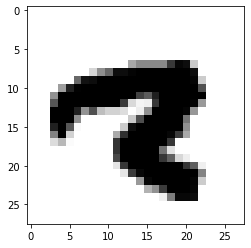

index 38
true label 9
prediction 4
top k [4 9 8] [0.7130156  0.22943974 0.05558274]


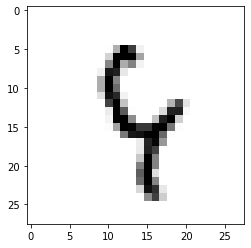

index 39
true label 8
prediction 2
top k [2 8 9] [0.845968   0.15402843 0.00000285]


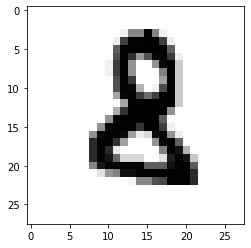

index 40
true label 5
prediction 3
top k [3 5 6] [0.54914516 0.45085374 0.0000007 ]


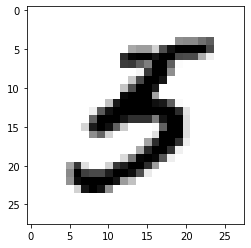

index 41
true label 4
prediction 8
top k [8 4 9] [0.65230507 0.34469146 0.00294694]


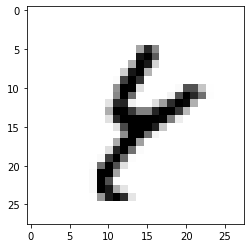

index 42
true label 4
prediction 9
top k [9 4 7] [0.51949024 0.4802227  0.00028418]


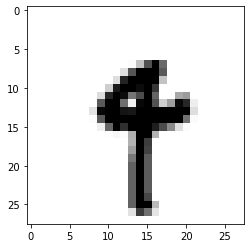

index 43
true label 7
prediction 9
top k [9 7 0] [0.66323245 0.32428423 0.0101693 ]


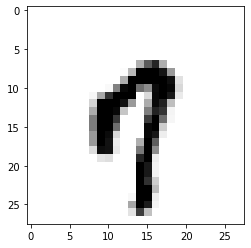

index 44
true label 2
prediction 0
top k [0 2 9] [0.55692554 0.44304097 0.00003241]


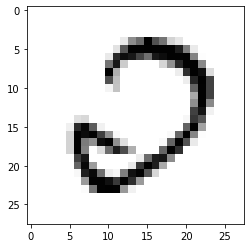

index 45
true label 3
prediction 9
top k [9 3 7] [0.57141846 0.21658133 0.19888726]


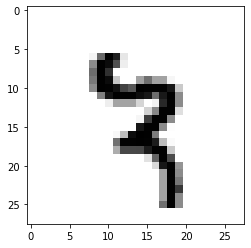

index 46
true label 6
prediction 0
top k [0 6 4] [0.8698249  0.12918304 0.00095147]


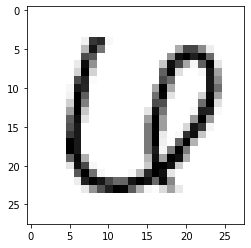

index 47
true label 4
prediction 9
top k [9 4 7] [0.99984086 0.000159   0.00000016]


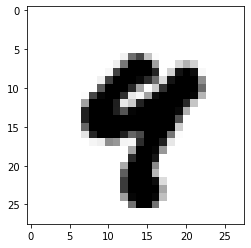

index 48
true label 6
prediction 1
top k [1 6 8] [0.9587631  0.0311972  0.00907154]


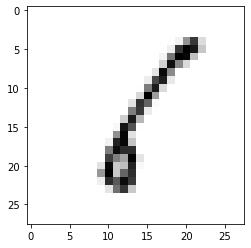

index 49
true label 3
prediction 5
top k [5 3 9] [0.70500976 0.29496947 0.00001942]


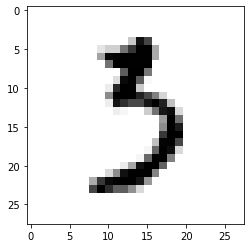

index 50
true label 9
prediction 0
top k [0 4 6] [0.6250067  0.21132958 0.10324901]


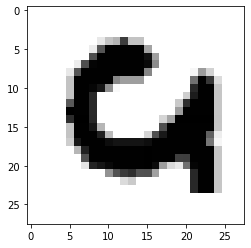

index 51
true label 5
prediction 6
top k [6 5 3] [0.68121445 0.17590353 0.14021297]


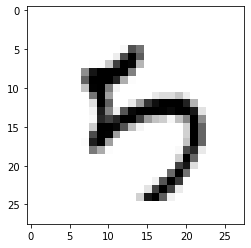

index 52
true label 9
prediction 1
top k [1 9 8] [0.5282957  0.46767017 0.00259682]


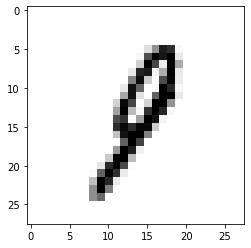

index 53
true label 2
prediction 0
top k [0 2 6] [0.88394445 0.11466456 0.0011932 ]


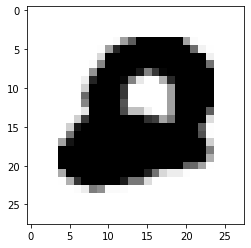

index 54
true label 5
prediction 3
top k [3 5 8] [0.9562325  0.04086469 0.00188038]


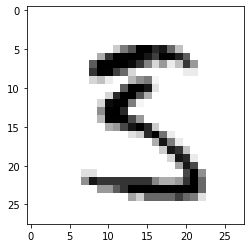

index 55
true label 6
prediction 1
top k [1 2 6] [0.99931717 0.00066984 0.00000802]


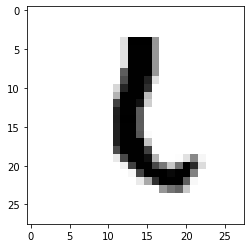

index 56
true label 4
prediction 8
top k [8 4 7] [0.61935973 0.36400282 0.01422475]


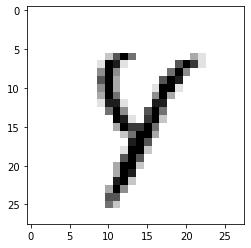

index 57
true label 4
prediction 9
top k [9 4 1] [0.66526586 0.33457235 0.00013884]


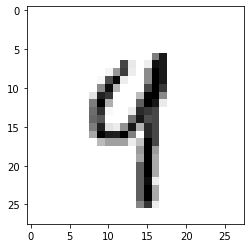

index 58
true label 4
prediction 0
top k [0 4 2] [0.909362  0.0818799 0.0041029]


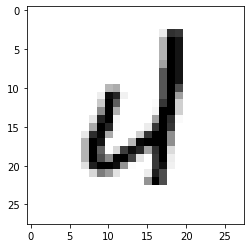

index 59
true label 4
prediction 2
top k [2 4 7] [0.8616502  0.13339743 0.0026518 ]


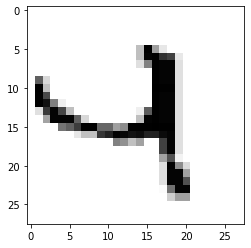

index 60
true label 8
prediction 0
top k [0 6 8] [0.99856085 0.00128682 0.00011954]


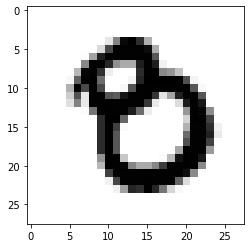

index 61
true label 3
prediction 8
top k [8 2 3] [0.9987847  0.00103819 0.00011777]


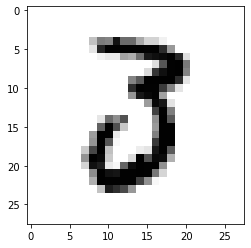

index 62
true label 3
prediction 2
top k [2 7 3] [0.6600021  0.32498232 0.01479034]


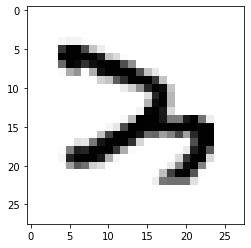

index 63
true label 9
prediction 5
top k [5 7 0] [0.66163236 0.29131472 0.02401801]


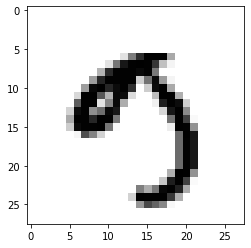

index 64
true label 3
prediction 9
top k [9 3 7] [0.88451    0.09931629 0.01617087]


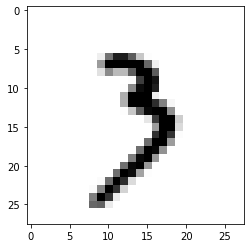

index 65
true label 3
prediction 5
top k [5 3 8] [0.9390605  0.04347212 0.01745177]


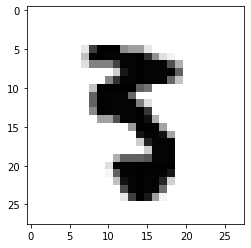

index 66
true label 6
prediction 0
top k [0 6 8] [0.9465908  0.05153595 0.00161829]


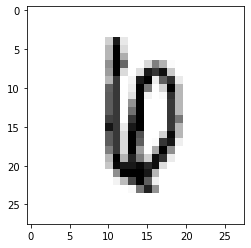

index 67
true label 1
prediction 2
top k [2 1 7] [0.76706475 0.23284198 0.00008691]


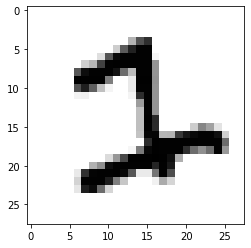

index 68
true label 7
prediction 9
top k [9 7 1] [0.509711   0.37093177 0.11873898]


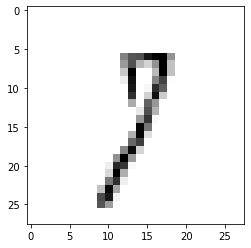

index 69
true label 8
prediction 9
top k [9 8 7] [0.98920995 0.01057103 0.00017027]


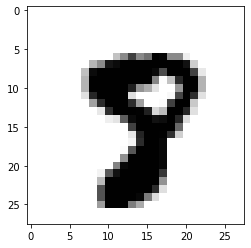

index 70
true label 2
prediction 6
top k [6 2 1] [0.9140769  0.07711789 0.00591596]


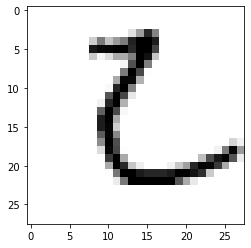

index 71
true label 6
prediction 0
top k [0 6 5] [0.5186405  0.48123795 0.00011615]


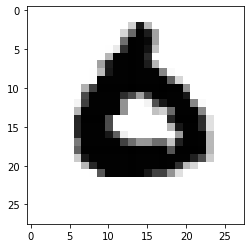

index 72
true label 7
prediction 9
top k [9 7 3] [0.53133225 0.44703954 0.01082169]


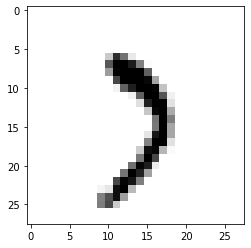

index 73
true label 3
prediction 7
top k [7 3 9] [0.8282161  0.09528009 0.07648625]


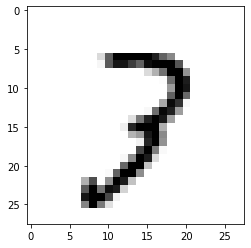

index 74
true label 9
prediction 1
top k [1 9 4] [0.72633815 0.23876204 0.03407552]


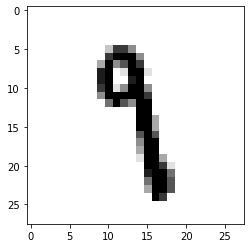

index 75
true label 6
prediction 4
top k [4 9 6] [0.9890665  0.00648572 0.0027543 ]


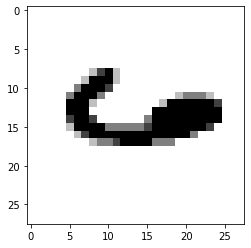

index 76
true label 5
prediction 0
top k [0 5 6] [0.8547833  0.1399709  0.00341118]


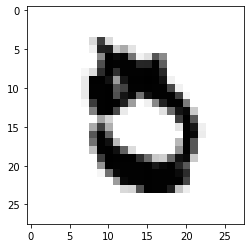

index 77
true label 8
prediction 5
top k [5 6 8] [0.5631938  0.31549117 0.09648231]


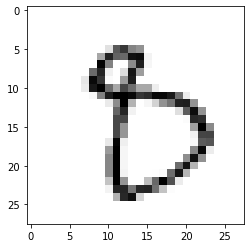

index 78
true label 5
prediction 6
top k [6 5 8] [0.6459902  0.3526257  0.00135658]


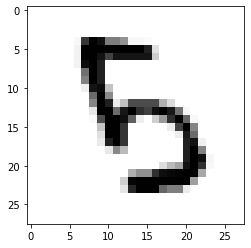

index 79
true label 2
prediction 7
top k [7 2 1] [0.6717547  0.32801998 0.00010919]


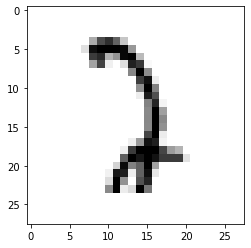

index 80
true label 8
prediction 6
top k [6 8 0] [0.73141557 0.2110429  0.05696881]


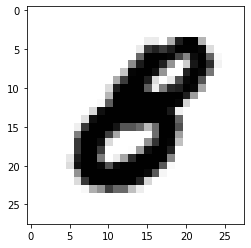

index 81
true label 4
prediction 9
top k [9 4 3] [0.9732967  0.02616812 0.00045677]


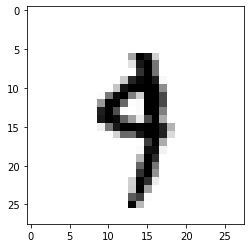

index 82
true label 8
prediction 9
top k [9 8 3] [0.99692816 0.00273668 0.00031641]


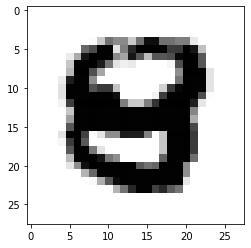

index 83
true label 2
prediction 8
top k [8 2 1] [0.7971895  0.11327732 0.08751065]


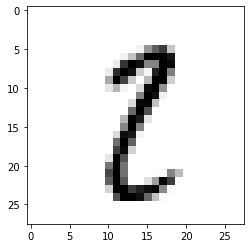

index 84
true label 7
prediction 8
top k [8 7 0] [0.9958306  0.0021718  0.00110128]


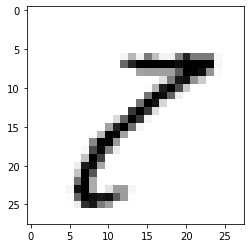

index 85
true label 5
prediction 3
top k [3 5 9] [0.7502322  0.24933642 0.00042618]


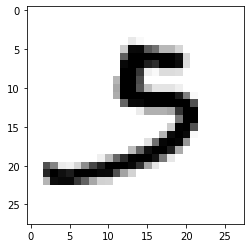

index 86
true label 1
prediction 2
top k [2 1 3] [0.77724236 0.13970622 0.08255239]


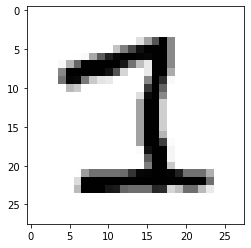

index 87
true label 3
prediction 5
top k [5 3 8] [0.6555859  0.3433097  0.00098491]


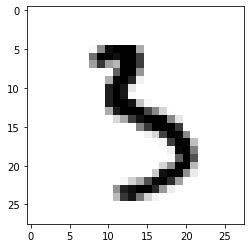

index 88
true label 8
prediction 6
top k [6 0 8] [0.9633762  0.03473394 0.00142636]


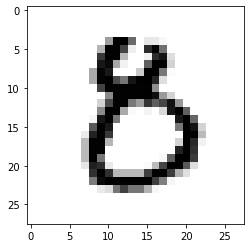

index 89
true label 8
prediction 2
top k [2 8 9] [0.8464845  0.15351209 0.00000337]


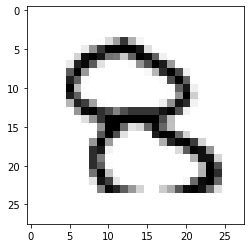

index 90
true label 9
prediction 0
top k [0 9 7] [0.46074888 0.34313557 0.19571862]


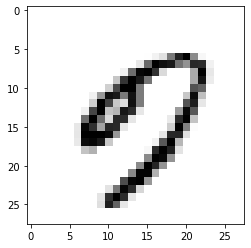

index 91
true label 2
prediction 7
top k [7 2 4] [0.99886096 0.00090438 0.00021987]


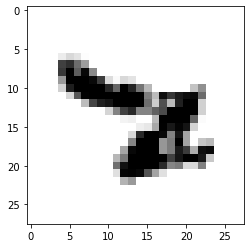

index 92
true label 1
prediction 7
top k [7 1 9] [0.55604905 0.44269907 0.00122566]


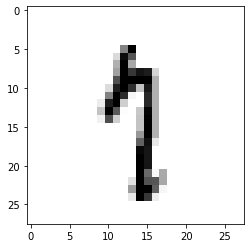

index 93
true label 2
prediction 1
top k [1 9 2] [0.96684384 0.02126023 0.00651243]


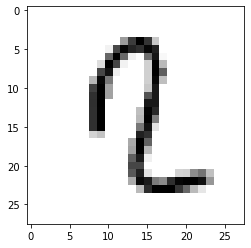

index 94
true label 3
prediction 2
top k [2 3 0] [0.7732334  0.15024383 0.07613468]


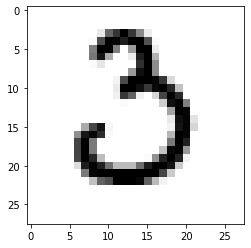

index 95
true label 9
prediction 4
top k [4 9 3] [0.5162898  0.48370996 0.00000012]


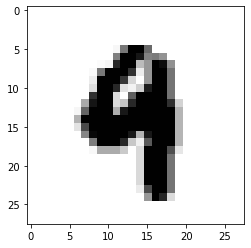

index 96
true label 3
prediction 2
top k [2 3 7] [0.46324632 0.29345968 0.22337747]


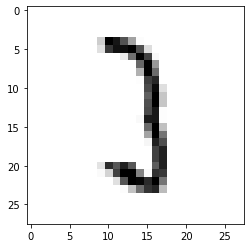

index 97
true label 8
prediction 7
top k [7 8 2] [0.9592079  0.0356847  0.00384032]


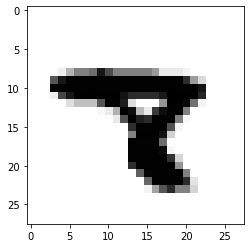

index 98
true label 4
prediction 2
top k [2 4 0] [0.76772296 0.15736714 0.06234637]


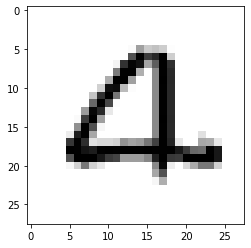

index 99
true label 7
prediction 9
top k [9 7 3] [0.5724751  0.42734095 0.00012938]


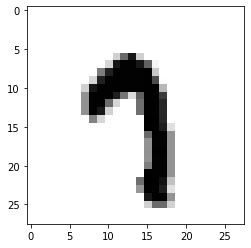

index 100
true label 3
prediction 5
top k [5 3 0] [0.9880483  0.00618361 0.00247929]


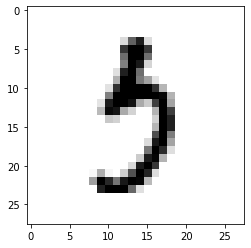

index 101
true label 4
prediction 6
top k [6 4 0] [0.9370581  0.05556706 0.00410032]


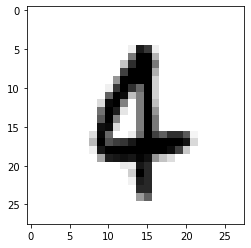

index 102
true label 5
prediction 6
top k [6 5 3] [0.7067087 0.2932814 0.0000042]


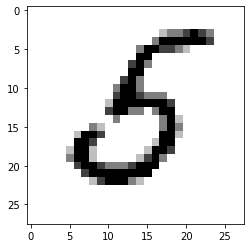

index 103
true label 4
prediction 9
top k [9 4 5] [0.75264007 0.24724416 0.00011562]


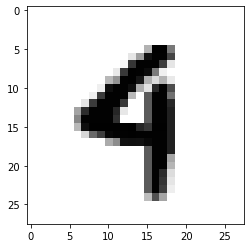

index 104
true label 8
prediction 0
top k [0 3 8] [0.9254267  0.03816011 0.03426366]


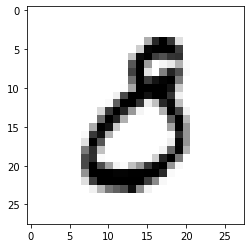

index 105
true label 3
prediction 2
top k [2 3 8] [0.54682726 0.4520031  0.00090597]


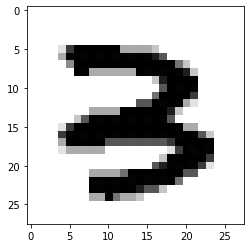

index 106
true label 4
prediction 9
top k [9 4 7] [0.9956226  0.00424857 0.00012812]


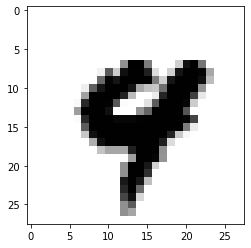

index 107
true label 4
prediction 9
top k [9 4 1] [0.6649371  0.33459073 0.00039419]


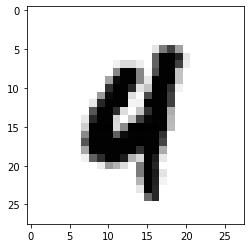

index 108
true label 4
prediction 9
top k [9 4 0] [0.7984062  0.20129621 0.00012835]


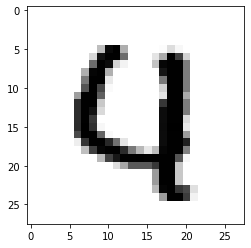

index 109
true label 3
prediction 7
top k [7 3 9] [0.9405667  0.03672295 0.0100136 ]


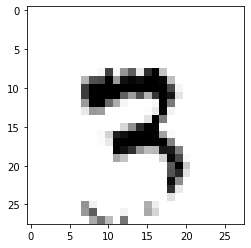

index 110
true label 5
prediction 3
top k [3 5 9] [0.63268614 0.36522862 0.00208312]


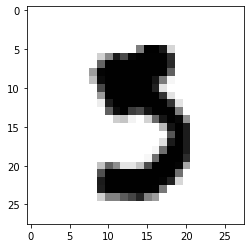

index 111
true label 3
prediction 8
top k [8 3 9] [0.9970156  0.00186136 0.0006324 ]


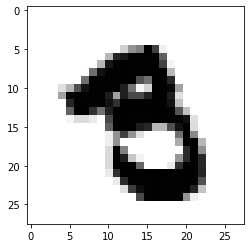

index 112
true label 3
prediction 8
top k [8 3 9] [0.505287   0.48289484 0.00861862]


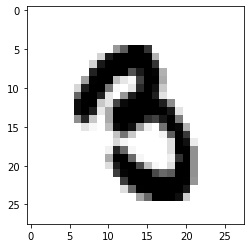

index 113
true label 0
prediction 6
top k [6 0 2] [0.6102855  0.38965744 0.00005492]


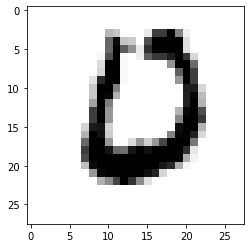

index 114
true label 0
prediction 5
top k [5 0 7] [0.94249755 0.05742751 0.00007278]


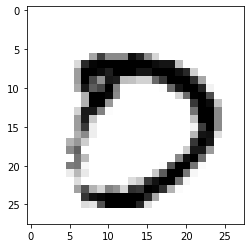

index 115
true label 8
prediction 9
top k [9 8 7] [0.99759597 0.00210618 0.00028572]


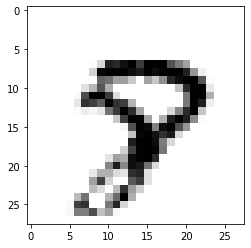

index 116
true label 2
prediction 6
top k [6 2 0] [0.9054214  0.09454937 0.00000959]


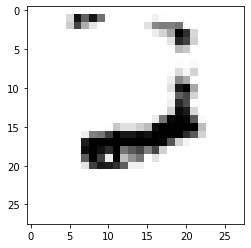

index 117
true label 7
prediction 1
top k [1 7 2] [0.66600436 0.3334565  0.00043204]


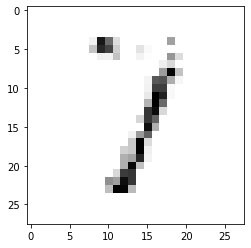

index 118
true label 0
prediction 9
top k [9 7 3] [0.5792394  0.33150643 0.08034756]


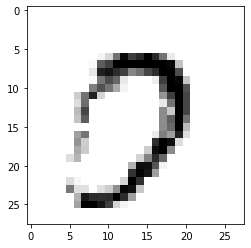

index 119
true label 8
prediction 9
top k [9 8 7] [0.7257603  0.24657969 0.02732359]


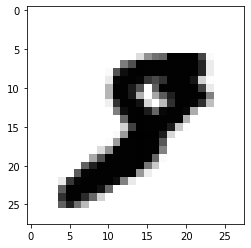

index 120
true label 1
prediction 6
top k [6 1 8] [0.86911964 0.12780465 0.00138185]


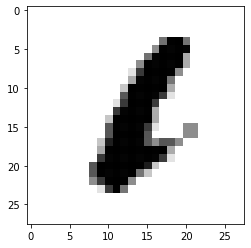

index 121
true label 8
prediction 9
top k [9 8 7] [0.85609394 0.13279873 0.00810728]


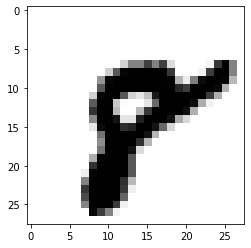

index 122
true label 4
prediction 8
top k [8 4 9] [0.67932236 0.2884701  0.01772009]


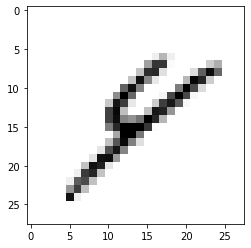

index 123
true label 4
prediction 1
top k [1 4 8] [0.67711294 0.32175395 0.00107586]


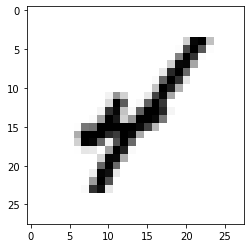

index 124
true label 8
prediction 9
top k [9 8 7] [0.80750364 0.19198577 0.00050959]


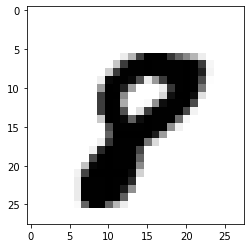

index 125
true label 2
prediction 8
top k [8 2 1] [0.66094136 0.18376614 0.15263055]


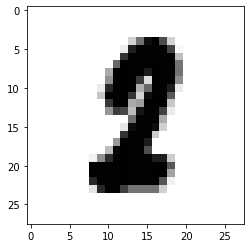

index 126
true label 3
prediction 9
top k [9 5 3] [0.96899724 0.02072742 0.01015022]


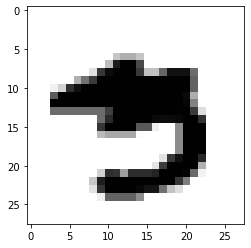

index 127
true label 0
prediction 6
top k [6 0 5] [0.9772727  0.02234579 0.00036745]


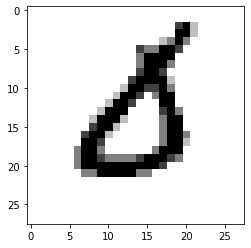

index 128
true label 8
prediction 5
top k [5 6 8] [0.54647195 0.3929427  0.0483764 ]


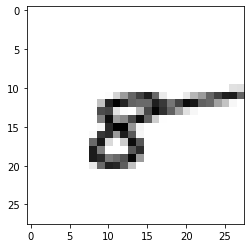

index 129
true label 4
prediction 9
top k [9 4 5] [0.99594057 0.00380783 0.00016463]


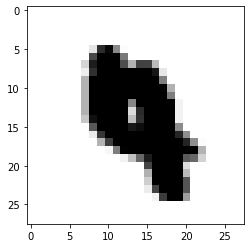

index 130
true label 7
prediction 2
top k [2 7 1] [0.8908205  0.10917314 0.00000486]


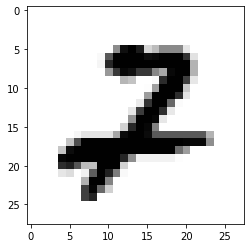

index 131
true label 7
prediction 2
top k [2 7 1] [0.9446468  0.05526477 0.00007136]


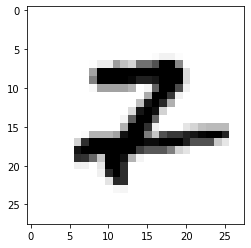

index 132
true label 7
prediction 2
top k [2 7 8] [0.6337873  0.36618826 0.00002353]


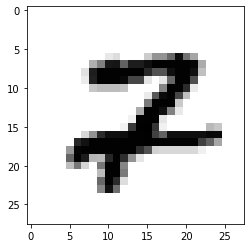

index 133
true label 2
prediction 7
top k [7 2 9] [0.9841411  0.01568642 0.00008038]


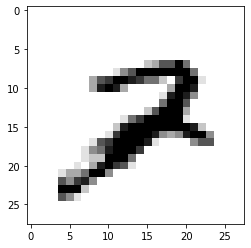

index 134
true label 6
prediction 5
top k [5 6 1] [0.8078616  0.18075424 0.01008754]


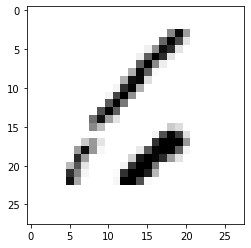

index 135
true label 5
prediction 6
top k [6 5 0] [0.9999677  0.00002244 0.00000687]


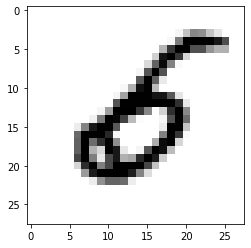

index 136
true label 2
prediction 3
top k [3 2 9] [0.6552841  0.33954543 0.00504402]


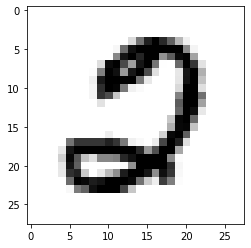

index 137
true label 5
prediction 0
top k [0 5 6] [0.64205515 0.3578875  0.0000268 ]


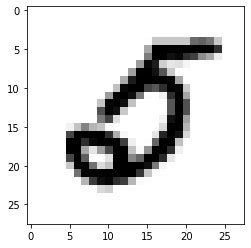

index 138
true label 4
prediction 9
top k [9 7 1] [0.64243895 0.3153549  0.03714769]


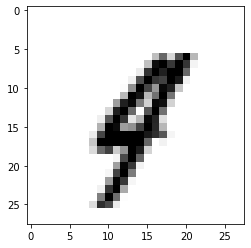

index 139
true label 2
prediction 7
top k [7 2 8] [0.7370736  0.25028855 0.0077134 ]


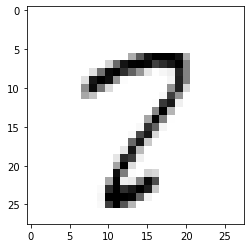

index 140
true label 3
prediction 9
top k [9 7 3] [0.49892604 0.36298817 0.11169031]


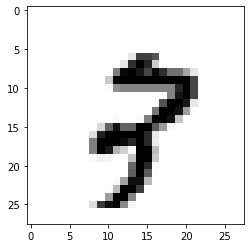

index 141
true label 3
prediction 2
top k [2 3 8] [0.86766845 0.12444308 0.00760731]


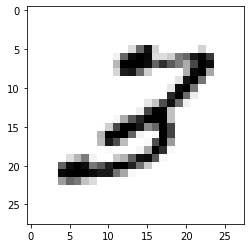

index 142
true label 5
prediction 6
top k [6 5 3] [0.9612762  0.0364682  0.00116572]


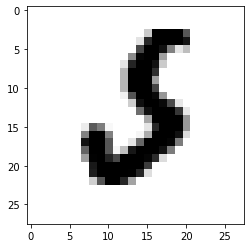

In [28]:
np.set_printoptions(suppress=True)

for i, error_prediction in enumerate(error_predictions):
  print("index", i)
  print("true label", error_labels[i])
  print("prediction", tf.math.argmax(error_prediction).numpy())

  top3 = tf.math.top_k(error_prediction, 3)
  print("top k", top3.indices.numpy(), top3.values.numpy())

  show_image(error_images, i)

convolution shape: (1, 26, 26, 32)


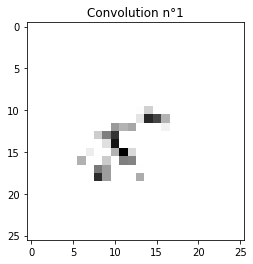

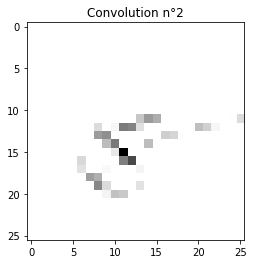

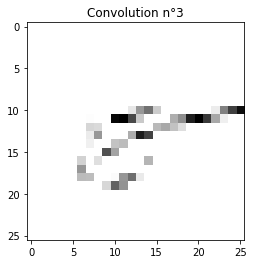

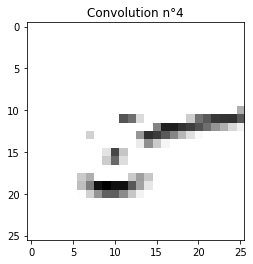

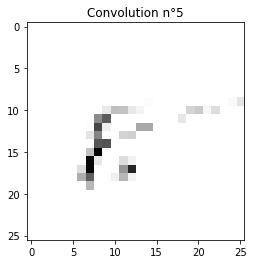

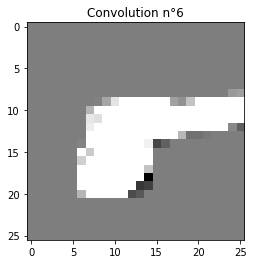

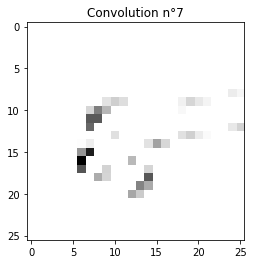

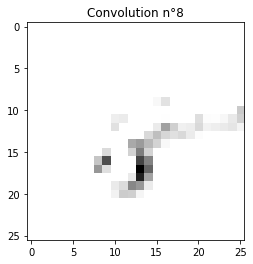

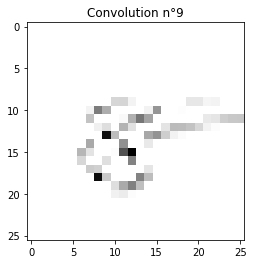

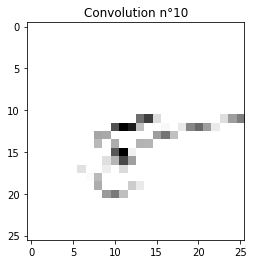

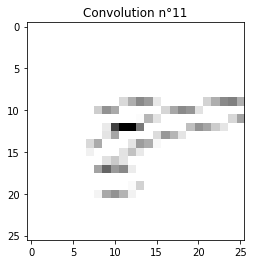

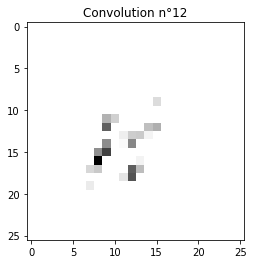

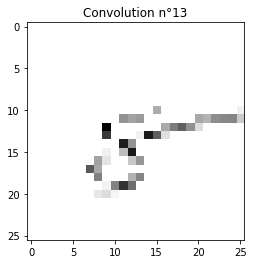

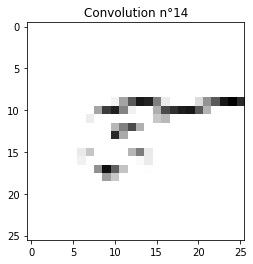

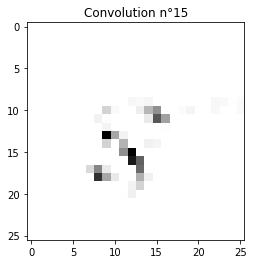

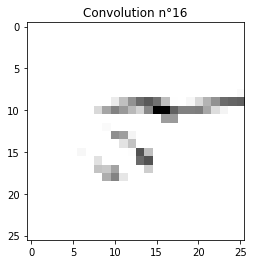

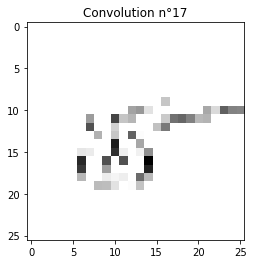

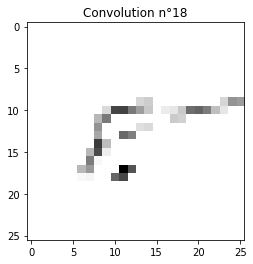

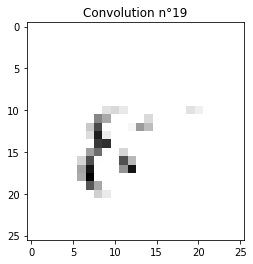

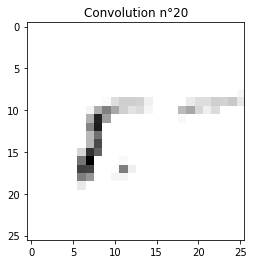

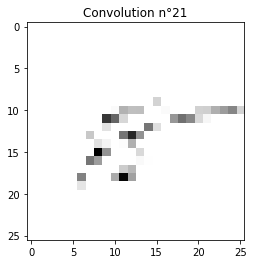

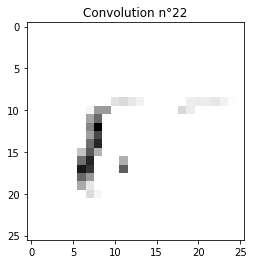

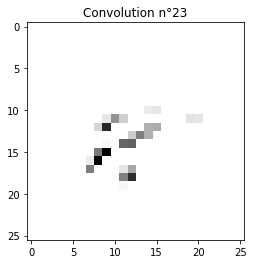

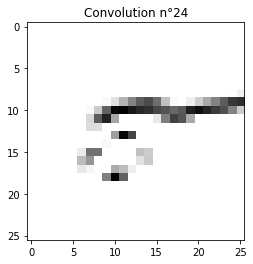

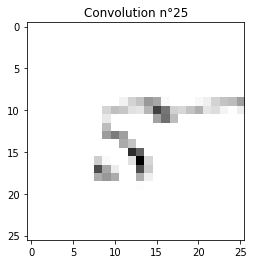

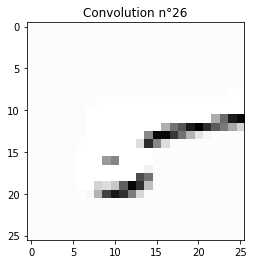

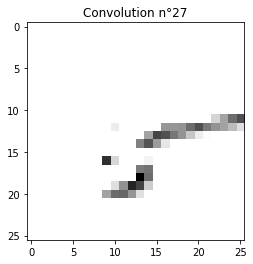

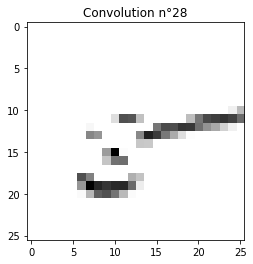

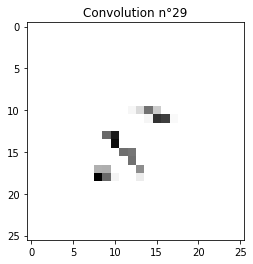

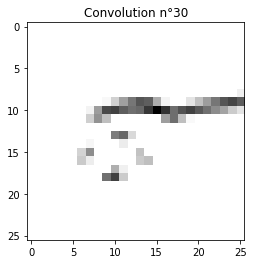

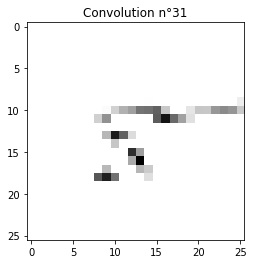

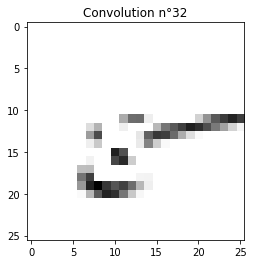

max pooling shape: (1, 13, 13, 32)


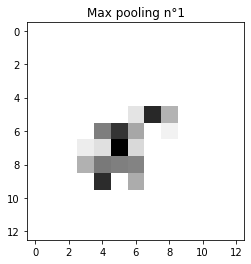

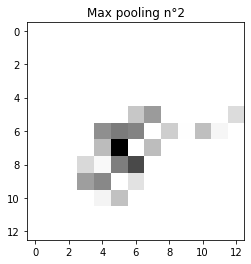

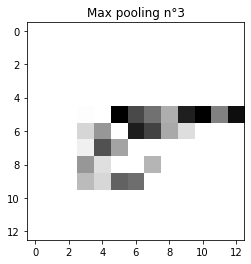

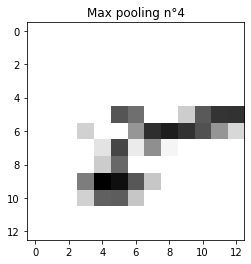

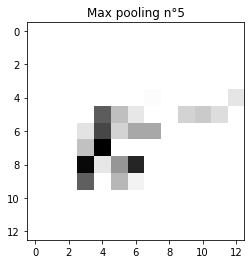

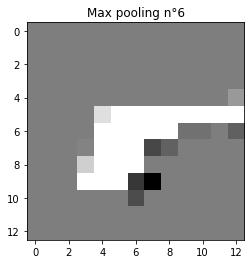

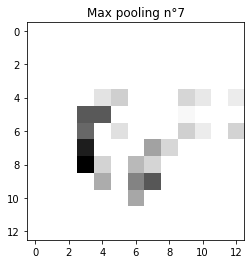

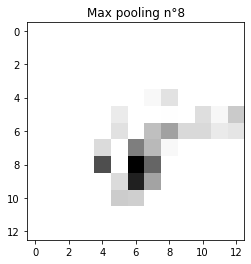

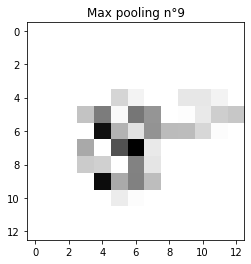

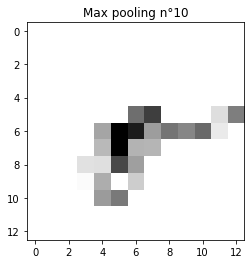

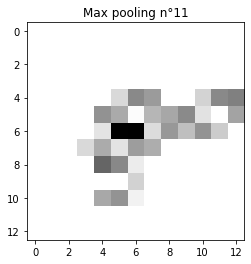

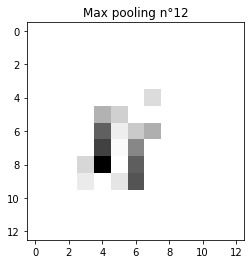

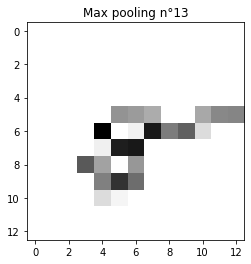

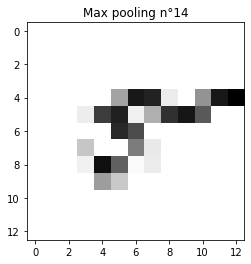

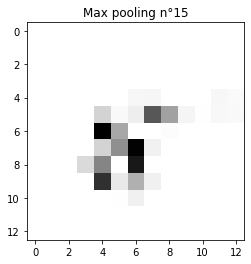

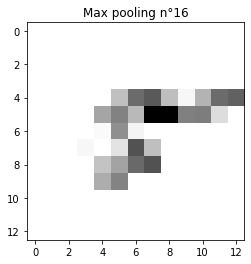

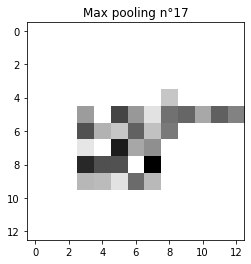

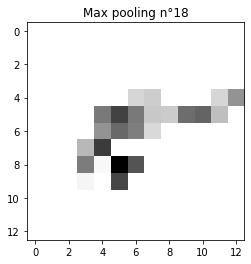

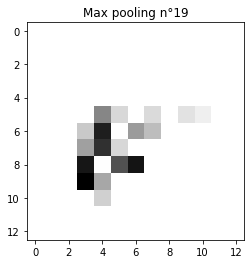

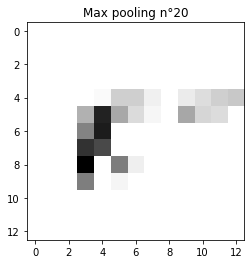

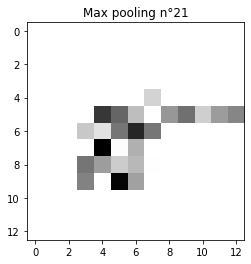

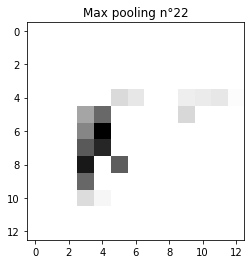

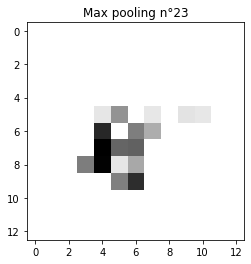

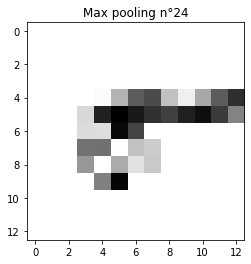

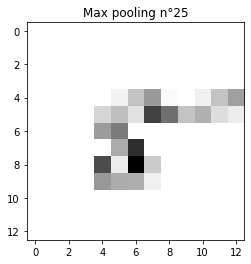

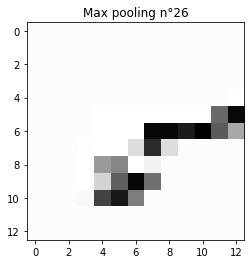

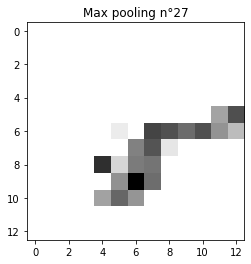

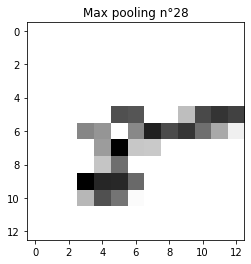

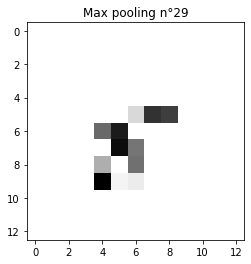

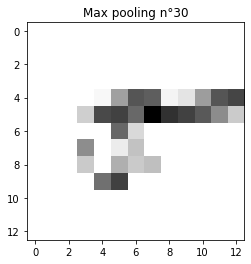

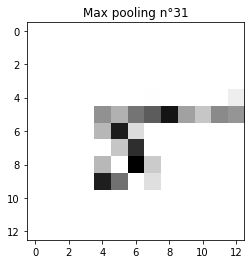

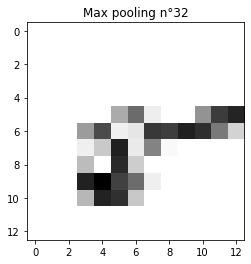

In [29]:
sample_index = 128
model(error_images[sample_index].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 1))

print_convolutions(model)
print_max_poolings(model)